In [1]:
#Adjustments AI 
#Sample data creator


In [12]:
#Shared common config
SpecialFields=["AdjustmentType","AdjustmentName","AdjustedField"]
AuditFields=["NewVal"]
SampleFields=["CustomerID","CustomerType","AccountType","Approach","RiskCategory","SubDivision","IsDefaulted","CountryCode"]
NumericFields=["Drawn","Undrawn"]
RatioFields=["PD"]
AdjustableFields=SampleFields+NumericFields+RatioFields #Used for thre adjustment mask
AdjustmentTypes=["Amend"]
AdjustmentNames=["Noise_6f","Noise_22d","Noise_116z","Noise_256n","Noise_128x","Noise_19b"]
AdjustedFields=SampleFields
CustomerID=["CUST238947","CUST563201","CUST981372","CUST450896","CUST712035","CUST103289","CUST665428","CUST359147","CUST804231","CUST192654"]
CustomerType=["Retail","Corporate","SME"]
RiskCategory=["Low","Medium","High"]
IsDefaulted=["0","1"]
CountryCode=["US","GB","DE"]
Approaches=["STD","FOU","ADV"]
SubDivisions=["HSBC_UK","HSBC_IR","HSBC_US","HSBC_AP","HSBC_CORP","HSBC_DEBTS"]
AccountTypes=["Current","Savings","Loan","Mortgage","Credit Card","Investment","Insurance","Other","Revolver"]
FieldMapping={"CustomerID":CustomerID,"CustomerType":CustomerType,"RiskCategory":RiskCategory,"IsDefaulted":IsDefaulted,"CountryCode":CountryCode,"Approach":Approaches,"SubDivision":SubDivisions,"AccountType":AccountTypes}
 


#Define adjustment rules
AdjustmentRules=[]
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"RiskCategory":"High"}],"Market Downturn",[["PD",0.75]]])
AdjustmentRules.append([[{"RiskCategory":"High"},{"IsDefaulted":"1"}],"Defaulting Cleanup",[["CustomerType","Debt Recovery"]]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"0"}],"BREXIT",[["RiskCategory","Medium"]]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"1"}],"BREXIT_DEFAULTED",[["RiskCategory","High"]]])
AdjustmentRules.append([[{"CountryCode":"DE"},{"CustomerType":"Retail"}],"German Retail Downturn",[["RiskCategory","Medium"]]])
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"CountryCode":"US"}],"US Corporate Crunch",[["PD",0.75]]])
AdjustmentRules.append([[{"Approach":"STD"},{"CountryCode":"US"}],"US STD downgrade",[["RiskCategory","High"]]])
AdjustmentRules.append([[{"AccountType":"Credit Card"}],"STD downgrade credit card",[["RiskCategory","High"]]])

#Multi adjustment rules
# AdjustmentRules.append([[{"AccountType":"Credit Card"}],"STD downgrade credit card",[["RiskCategory","High"],["CustomerType","HiInterest Creddit Card"]]])

In [14]:
#Generate random data with Adjustment rules applied
import pandas as pd
import numpy as np

#Sample Data Generator
records=20000

#Hide warmings from pandas
pd.options.mode.chained_assignment = None  # default='warn'

def GetRandomFieldValue(field):
    return np.random.choice(FieldMapping[field],1)[0]

#Checks if this row matches any adjustment rule, if so returns the [{fieldToUpdate:NewValue},AdjustmentComment]
def ValidateGetAdjustmentRule(row):
    for rule in AdjustmentRules:
        criteria=rule[0]
        comment=rule[1]
        adjustments=rule[2]

        #Check all criteria match
        allMatch=True
        for crit in criteria:
            #Split crit dictionary into key and value
            critField=list(crit.keys())[0]
            critValue=crit[critField]

            #Check if row matched
            if row[critField]!=critValue:
                allMatch=False
        
        if allMatch:
            return True,comment,adjustments
    
    return False,"",[]

#Accrue an adjustment mask for training
AdjustmentMask=[]

#Build numeric column mapping for Adjustable Fields
MaskMapping={}
for i in range(len(AdjustableFields)):
    MaskMapping[AdjustableFields[i]]=i+1
print(MaskMapping)

df=pd.DataFrame(columns=SampleFields+SpecialFields+AuditFields)
for mapping in FieldMapping:
    df[mapping]=np.random.choice(FieldMapping[mapping],records)
df["AdjustmentType"]=np.random.choice(AdjustmentTypes,records)
df["AdjustmentName"]=np.random.choice(AdjustmentNames,records)

#Adjusted field------------------------------------------------------------------------
df["AdjustedField"]=np.random.choice(AdjustedFields,records)
#df["AdjustedField"]="CustomerType"

for field in NumericFields:
    #Insert new column after first 1
    df[field]=np.random.randint(1000000, size=records)
for field in RatioFields:
    df[field]=np.random.randint(100, size=records)/100

#Add in audit fields
df["NewVal"]=np.nan

#make new dataframe from df with 0 rows
dfMultiRowAdj=df.iloc[0:0]

#Loop over each row and generate a new value for Oldval based on field
for index, row in df.iterrows():
    adjField=row["AdjustedField"]

    #Build empty adjustment mask
    RowMask=[""]+[0]*len(AdjustableFields)

    #Check if this row matches any adjustment rule
    matchesRule,comment,rules = ValidateGetAdjustmentRule(row)

    #APPLY ADJUSTMENTS--------------------------------------
    if adjField not in NumericFields and adjField not in RatioFields:

        if matchesRule:

            #Copy row for multi row adjustments
            ogdupeRow=row.copy()

            #Apply first rule to the base rowset
            rule=rules[0]
            ruleComment=comment
            ruleTarget=rule[0]
            ruleValue=rule[1]
            df["AdjustmentName"][index]=ruleComment
            df["AdjustedField"][index]=ruleTarget
            df["NewVal"][index]=ruleValue
            #Update current rowMask
            RowMask[MaskMapping[ruleTarget]]=1
            RowMask[0]=ruleComment

            #For 1 to lenth of rules, apply the rule to the dupe row
            for i in range(1,len(rules)):
                dupeRow=ogdupeRow.copy()
                rule=rules[i]
                ruleComment=comment
                ruleTarget=rule[0]
                ruleValue=rule[1]
                dupeRow["AdjustmentName"]=ruleComment
                dupeRow["AdjustedField"]=ruleTarget
                dupeRow["NewVal"]=ruleValue
                #Update current rowMask
                RowMask[MaskMapping[ruleTarget]]=1
                RowMask[0]=ruleComment

                #Append to the multirow dataframe
                dfMultiRowAdj=dfMultiRowAdj.append(dupeRow,ignore_index=True)

        else:
            #Update current rowMask
            RowMask[MaskMapping[adjField]]=1
            RowMask[0]=df["AdjustmentName"][index]

            #Random "noise" adjustments
            df["NewVal"][index]=GetRandomFieldValue(adjField)

        #Accrue row masks --------------------------------------
        AdjustmentMask.append(RowMask)

# #Reshuffle the numeric fields to the start
df=df.reindex(columns=SpecialFields+NumericFields+RatioFields+SampleFields+AuditFields)

#Append dfMultiRowAdj to df
df=df.append(dfMultiRowAdj,ignore_index=True)

# #Write to CSV file
df.to_csv("SampleData.csv",index=False)

#Make Adustment Mask dataframe
dfMask=pd.DataFrame(AdjustmentMask,columns=["AdjustmentName"]+AdjustableFields)
dfMask.to_csv("AdjustmentMask.csv",index=False)

df

{'CustomerID': 1, 'CustomerType': 2, 'AccountType': 3, 'Approach': 4, 'RiskCategory': 5, 'SubDivision': 6, 'IsDefaulted': 7, 'CountryCode': 8, 'Drawn': 9, 'Undrawn': 10, 'PD': 11}


C:\Users\simon\AppData\Local\Temp\ipykernel_79028\4057278263.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(dfMultiRowAdj,ignore_index=True)


,AdjustmentType,AdjustmentName,AdjustedField,Drawn,Undrawn,PD,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,NewVal
0,Amend,German Retail Downturn,RiskCategory,124553,870304,0.55,CUST563201,Retail,Other,ADV,Low,HSBC_IR,0,DE,Medium
1,Amend,BREXIT_DEFAULTED,RiskCategory,83665,348195,0.39,CUST450896,Retail,Revolver,ADV,Medium,HSBC_UK,1,GB,High
2,Amend,BREXIT,RiskCategory,391137,61592,0.12,CUST238947,SME,Current,ADV,Low,HSBC_US,0,GB,Medium
3,Amend,Noise_19b,CustomerID,643761,288541,0.39,CUST359147,Retail,Investment,FOU,High,HSBC_US,0,US,CUST665428
4,Amend,Noise_22d,CustomerID,181927,540516,0.69,CUST563201,SME,Mortgage,FOU,Medium,HSBC_US,0,DE,CUST981372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Amend,Defaulting Cleanup,CustomerType,955591,2890,0.61,CUST450896,Retail,Investment,STD,High,HSBC_IR,1,GB,Debt Recovery
19996,Amend,BREXIT_DEFAULTED,RiskCategory,351152,56582,0.29,CUST665428,Retail,Insurance,ADV,Medium,HSBC_IR,1,GB,High
19997,Amend,Noise_22d,CountryCode,251993,768438,0.12,CUST450896,SME,Loan,ADV,Medium,HSBC_DEBTS,0,US,US
19998,Amend,Noise_6f,Approach,22468,734705,0.97,CUST981372,Corporate,Current,STD,Low,HSBC_US,1,DE,FOU


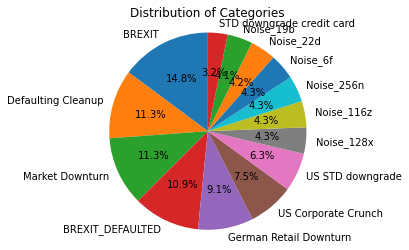

In [15]:
import matplotlib.pyplot as plt
# Replace 'Category' with the field you want to visualize
frequency = df['AdjustmentName'].value_counts()

# Plot the pie chart
plt.pie(frequency, labels=frequency.index, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of Categories')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

#Make background white
plt.rcParams['axes.facecolor'] = 'white'

#Make background solid
plt.rcParams['axes.edgecolor'] = 'black'

# Display the chart
plt.show()


In [7]:
#------------------Produce a sample adjustment template with some fake data to adjust---------------------------------
sampleRows=4000
dfTemplate=pd.DataFrame(columns=["AdjustmentName"] + SampleFields+NumericFields+RatioFields)
for col in SampleFields:
    if col!="AdjustmentName":
        dfTemplate[col]=np.random.choice(FieldMapping[col],sampleRows)

dfTemplate



,AdjustmentName,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,Drawn,Undrawn,PD
0,NaN,CUST804231,Corporate,Revolver,ADV,Low,HSBC_IR,1,US,NaN,NaN,NaN
1,NaN,CUST359147,Retail,Investment,STD,Low,HSBC_UK,0,GB,NaN,NaN,NaN
2,NaN,CUST103289,Corporate,Revolver,ADV,Low,HSBC_US,0,GB,NaN,NaN,NaN
3,NaN,CUST712035,SME,Revolver,ADV,Medium,HSBC_AP,0,US,NaN,NaN,NaN
4,NaN,CUST981372,Corporate,Current,FOU,Medium,HSBC_UK,0,GB,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,CUST563201,Retail,Other,FOU,Low,HSBC_CORP,0,DE,NaN,NaN,NaN
3996,NaN,CUST450896,Corporate,Insurance,ADV,High,HSBC_UK,0,US,NaN,NaN,NaN
3997,NaN,CUST563201,Corporate,Loan,STD,Medium,HSBC_DEBTS,1,GB,NaN,NaN,NaN
3998,NaN,CUST981372,Retail,Mortgage,FOU,Medium,HSBC_IR,1,US,NaN,NaN,NaN


In [9]:
len(df["NewVal"].unique())

41